In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

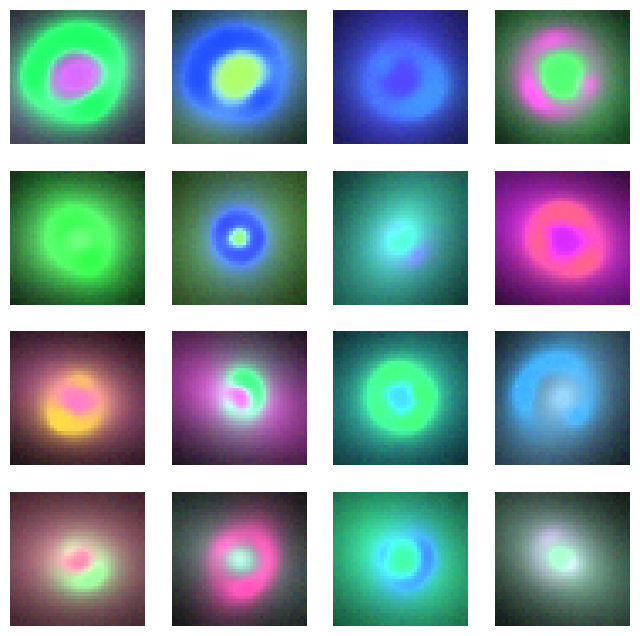

In [3]:
# Visualize source data
visualize_data(source_data)

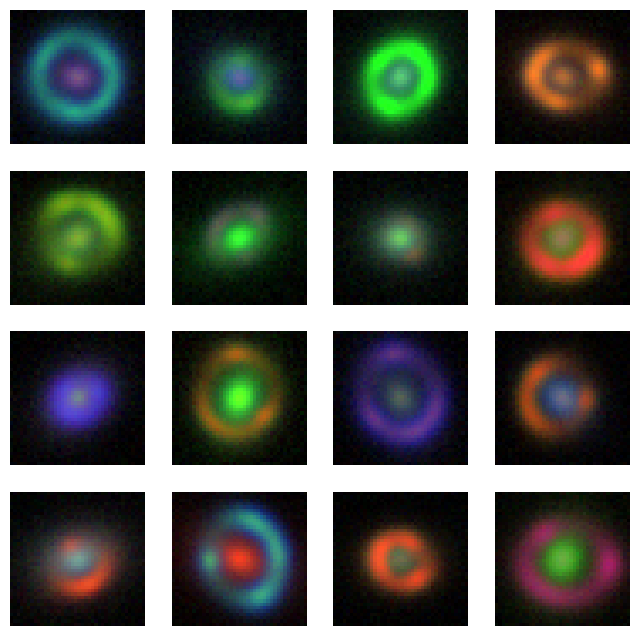

In [4]:
# Visualize target data
visualize_data(target_data)

In [5]:
# Define and initialize model
class NeuralNetwork(nn.Module):
    def __init__(self, npix):
        super(NeuralNetwork, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('r_relu1', nn.ReLU(True))
        self.regressor.add_module('r_fc3', nn.Linear(in_features=128, out_features=2))

        self.npix = npix

    def forward(self, x):
        x = x.view(-1, 3, self.npix, self.npix)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1, 2)

        return estimate, features


    def get_feature(self, x):
        x = x.view(-1, 3, self.npix, self.npix)
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        return features

In [6]:
def loss_bnll(mean, variance, truth, beta, epsilon = 1e-7):  # beta=0.5):
    """Compute beta-NLL loss

    :param mean: Predicted mean of shape B x D
    :param variance: Predicted variance of shape B x D
    :param truth: truth of shape B x D
    :param beta: Parameter from range [0, 1] controlling relative
        weighting between data points, where `0` corresponds to
        high weight on low error points and `1` to an equal weighting.
    :returns: Loss per batch element of shape B
    """
    variance = variance + epsilon
    loss = 0.5 * ((truth - mean) ** 2 / variance + variance.log())
    if beta > 0:
        loss = loss * (variance.detach() ** beta)
    return loss.sum(axis=-1) / len(mean)

In [7]:
# Define training loop
def train_loop(source_dataloader, 
               target_dataloader, 
               model, 
               regressor_loss_fn,
               da_loss,
               optimizer,
               n_epoch,
               epoch,
               init_wt_da,
               final_wt_da,
               beta_init,
               beta_final):
               # init_wt_mve,
               # final_wt_mve):
    """
    Trains the Neural Network on Source/Target Domains with the following loss:
        Loss = Source Regression Loss + 1.4 * DA MMD Loss
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss).
	optimizer: Optimizer for the model parameters.
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    domain_error = 0
    domain_classifier_accuracy = 0
    estimator_error = 0
    mve_error = 0
    score_list = np.array([])

    # Iteration length is shorter of the two datasets
    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)

    # Iterate over the two datasets
    i = 0
    while i < len_dataloader:

        # Time-varying hyperparameter, p 0 -> infty, alpha 0 -> 1
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader # UNUSED
        alpha = 2. / (1. + np.exp(-10 * p)) - 1 # UNUSED

        # Source Training

        # Load a batch of source data, move to GPU
        data_source = next(data_source_iter)
        X, y = data_source
        X = X.float()
        X = X.cuda()
        y = y.cuda()

        # Zero model gradients and labels
        model.zero_grad()
        batch_size = len(y)

        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        domain_label = domain_label.cuda()

        # Apply data to model and get predictions, embeddings, apply gradients
        estimate_output, domain_output_source = model(X)
        mean = estimate_output[:, 0]
        variance = estimate_output[:, 1]

        # print(y.shape)
        # print(mean.shape)
        # Calculate source regression loss based on predictions
        estimate_loss = regressor_loss_fn(mean, y)

        
        # Target Training

        data_target = next(data_target_iter)
        X_target, _ = data_target
        X_target = X_target.float()
        X_target = X_target.cuda()

        batch_size = len(X_target)

        _, domain_output_target = model(X_target)

        # Calculate the DA Loss between source and target, MMD loss
        domain_loss = da_loss(domain_output_source, domain_output_target)
        beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
        mve_loss = loss_bnll(mean.flatten(), variance.flatten(), y, beta = beta_val)
        
        # Hyperparameter of da_weight set to weight domain loss vs source loss
        # Perhaps this is where alpha was initially used
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
        # mve_weight_power = (init_wt_mve - ((init_wt_mve - final_wt_mve) * (epoch / n_epoch)))
        # mve_weight = 10 ** (-mve_weight_power)

        # Calculate the R2 score of the predictions vs. labels
        score = r2_score(y.cpu().detach().numpy(), mean.cpu().detach().numpy())

        loss = mve_loss + domain_loss * da_weight 

        
        
        # Backpropagation, update optimizer lr
        loss.backward()
        optimizer.step()

        # Update values
        
        # Domain loss is the DA loss or MMD loss between embedding outputs
        domain_error += domain_loss.item()

        # Estimator loss is the source data loss on regression
        estimator_error += estimate_loss.item()

        mve_error += mve_loss.item()

        score_list = np.append(score_list, score)

        i += 1

    # Calculate average scores/errors of batches for this epoch
    score = np.mean(score_list)
    domain_error = domain_error / (len_dataloader)
    estimator_error /= len_dataloader
    mve_error /= len_dataloader

    return [domain_error, estimator_error, mve_error, score]

In [8]:
def test_loop(source_dataloader, 
              target_dataloader, 
              model, 
              regressor_loss_fn, 
              da_loss, 
              n_epoch, 
              epoch,
              beta_init,
              beta_final):
    """
    Tests the model accuracy.
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss). UNUSED
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    
    # Evaluating without gradient computation in bg for validation
    with torch.no_grad():
        
        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        data_source_iter = iter(source_dataloader)
        data_target_iter = iter(target_dataloader)

        
        domain_classifier_error = 0
        domain_classifier_accuracy = 0
        estimator_error = 0
        estimator_error_target = 0
        mve_error = 0
        mve_error_target = 0
        score_list = np.array([])
        score_list_target = np.array([])

        i = 0
        while i < len_dataloader:

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # Source Testing

            data_source = next(data_source_iter)
            X, y = data_source
            X = X.float()
            X = X.cuda()
            y = y.cuda()

            batch_size = len(y)

            estimate_output, domain_output = model(X)
            source_mean = estimate_output[:, 0]
            source_variance = estimate_output[:, 1]
            beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
            
            estimate_loss = regressor_loss_fn(source_mean, y)
            mve_loss = loss_bnll(source_mean.flatten(), source_variance.flatten(), y, beta = beta_val)

            # Target Testing

            data_target = next(data_target_iter)
            X_target, y_target = data_target
            X_target = X_target.float()
            X_target = X_target.cuda()
            y_target = y_target.cuda()

            batch_size = len(X_target)

            estimate_output_target, domain_output = model(X_target)
            target_mean = estimate_output_target[:, 0]
            target_variance = estimate_output_target[:, 1]
            
            estimate_loss_target = regressor_loss_fn(target_mean, y_target)
            mve_loss_target = loss_bnll(target_mean.flatten(), target_variance.flatten(), y_target, beta = beta_val)
            
            # Update values

            # Regression loss on validation testing
            estimator_error += estimate_loss.item()
            estimator_error_target += estimate_loss_target.item()

            # MVE loss on validation testing
            mve_error += mve_loss.item()
            mve_error_target += mve_loss_target.item()

            # R2 Scores on validation testing
            score = r2_score(y.cpu(), source_mean.cpu())
            score_list = np.append(score_list, score)
            score_target = r2_score(y_target.cpu(), target_mean.cpu())
            score_list_target = np.append(score_list_target, score_target)

            i += 1

        score = np.mean(score_list)
        score_target = np.mean(score_list_target)
        estimator_error /= len_dataloader
        estimator_error_target /= len_dataloader
        mve_error /= len_dataloader
        mve_error_target /= len_dataloader
        
    classifier_error = 1 # UNUSED, legacy
    return [classifier_error, estimator_error, estimator_error_target, score, score_target, mve_error, mve_error_target]

In [9]:
model = NeuralNetwork(npix=40).cuda()
learning_rate = 2e-5
epochs = 75
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()

# Try to adjust momentum -> see if that helps
# Try SGD, Adadelta, see if that helps
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [10]:
mod_name = None#"models/mb_lenscolor_jul25_1700" #
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_mve_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[],
             'val_source_mve_loss': [],
             'val_target_mve_loss': [],
            'epoch_no': 0}
if mod_name is not None:
    state = torch.load(mod_name)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    stat_file = Path(mod_name+'.json')
    if stat_file.is_file():
        stats = json.load(open(mod_name+'.json', 'r'))

In [11]:
print("Beginning Training...")
mod_name = "models/mb_mvebeta_75epoch_aug2_0000"
# Train
best_target_R2 = -1.0
for i in range(stats['epoch_no'], stats['epoch_no'] + epochs):
        # if (i % 5 == 0):
        #     print("Generating Isomap...")
        #     source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
        #     show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 15000, 50, save = True)
        if (len(stats['val_target_r2_score']) > 0) and (stats['val_target_r2_score'][-1] > best_target_R2):
            print("Saving Model...", end = ' ')
            state = {
                    'epoch': stats['epoch_no'],
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    }
            json.dump(stats, open(mod_name+'.json', 'w'))
            torch.save(state, mod_name)
            best_target_R2 = stats['val_target_r2_score'][-1]
            print("Done.")
            
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i, init_wt_da = 1.4, final_wt_da = 1.4, beta_init = 1, beta_final = 0.0)
#                         init_wt_mve = 6, final_wt_mve = 2)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i, beta_init = 1, beta_final = 0.0)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])
        stats['val_source_mve_loss'].append(vals_validate[5])
        stats['val_target_mve_loss'].append(vals_validate[6])
        stats['epoch_no'] += 1

        
        print_epoch_scores(stats, i, time.time() - start_time)

Beginning Training...

Epoch 0: 22.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3768
	Train Regression Loss: : 0.9861
	Train Mve Loss: : 0.4409
	Train R2 Score: : -2.1079
 Validation Statistics:
	Val Source Regression Loss: : 0.1725
	Val Target Regression Loss: : 0.2009
	Val Source R2 Score: : 0.4594
	Val Target R2 Score: : 0.3623
	Val Source Mve Loss: : -0.0676
	Val Target Mve Loss: : -0.0495
Saving Model... Done.

Epoch 1: 20.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2238
	Train Regression Loss: : 0.1100
	Train Mve Loss: : -0.0828
	Train R2 Score: : 0.6540
 Validation Statistics:
	Val Source Regression Loss: : 0.0837
	Val Target Regression Loss: : 0.1086
	Val Source R2 Score: : 0.7324
	Val Target R2 Score: : 0.6562
	Val Source Mve Loss: : -0.0819
	Val Target Mve Loss: : -0.0811
Saving Model... Done.

Epoch 2: 19.73s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1867
	Train Regression Loss

In [12]:
state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
mod_name = "models/mb_mvebetaFinal_75epoch_aug2_0000"
torch.save(state, mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

mod_name = "models/mb_lenscolor_jul25_1740"
model.load_state_dict(torch.load(mod_name)['state_dict'])
stats = json.load(open(mod_name+'.json', 'r'))

def generate_isomaps(source_data, target_data, model, n_neighbors = 5, n_components = 2, n_points = 1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    catdata = np.concatenate((sdata, tdata), axis=0)
    print(catdata.shape)
    isomap = isomap.fit(catdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        catfeat = np.concatenate((sfeat, tfeat), axis=0)
        
    train_isomap = train_isomap.fit(catfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso


In [108]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

(2000, 6075)


def show_isomaps(source_iso, 
                 target_iso, 
                 trained_source_iso, 
                 trained_target_iso, 
                 source_labels,
                 target_labels,
                 mod_name, 
                 epoch_no,
                 pretrain_lim = 500,
                 posttrain_lim = 50,
                 save = False):
    
    fig0, axes = plt.subplots(1, 2, figsize=(8, 4))

    (ax1, ax2) = axes
    ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
    ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
    lval1 = pretrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Source and Target')
    
    ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
    ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
    lval2 = posttrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Trained Source and Target')
    
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_compare.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    fig1, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = ax[0][1]
    scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Source')
    
    ax2 = ax[0][0]
    ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Source')
    
    ax1 = ax[1][1]
    ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Target')
    
    ax2 = ax[1][0]
    ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Target')
    
    for i in ax.ravel():
        i.set_xlabel('Component 1')
        i.set_ylabel('Component 2')
    
    cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
    cbar.set_label('$\\theta_E$')
    
    plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_thetaE.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    return fig0, axes, fig1, ax

In [109]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

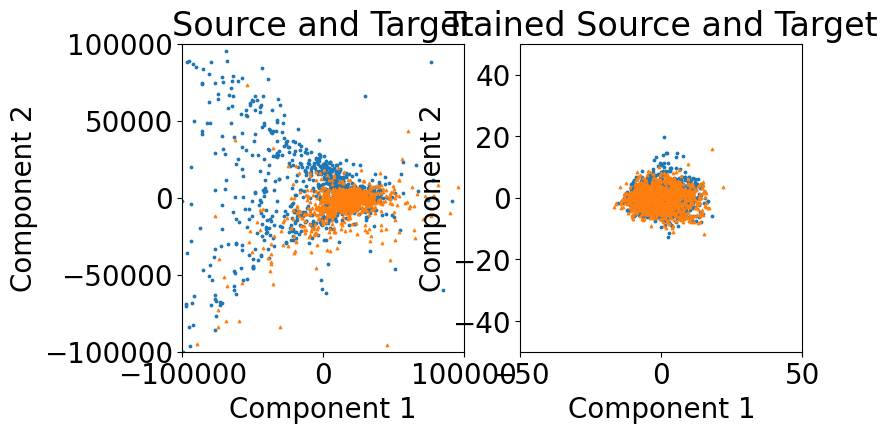

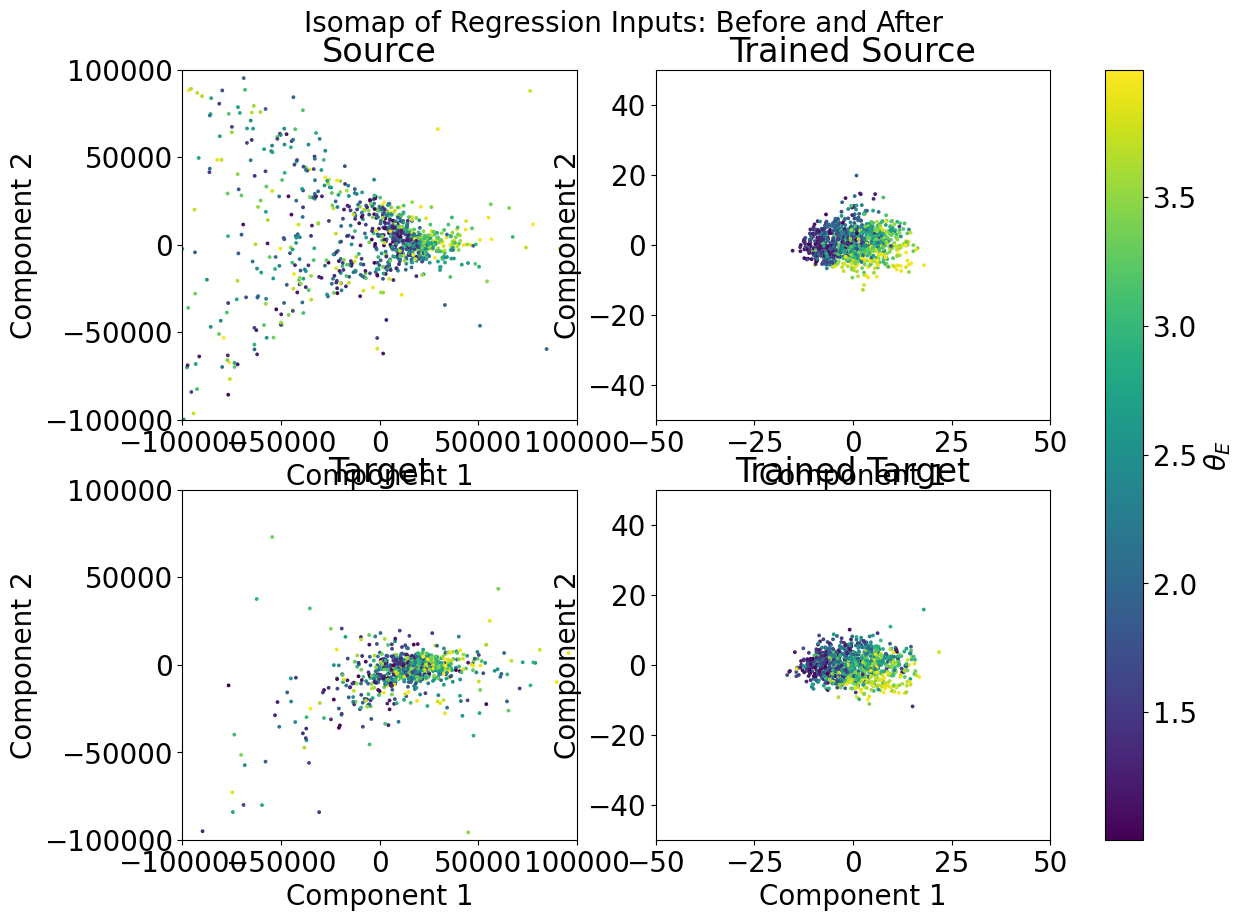

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Trained Source and Target'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object),
 <Figure size 1400x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'Source'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Source'}, xlabel='Component 1', ylabel='Component 2'>],
        [<Axes: title={'center': 'Target'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Target'}, xlabel='Component 1', ylabel='Component 2'>]],
       dtype=object))

In [110]:
show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 100000, 50)

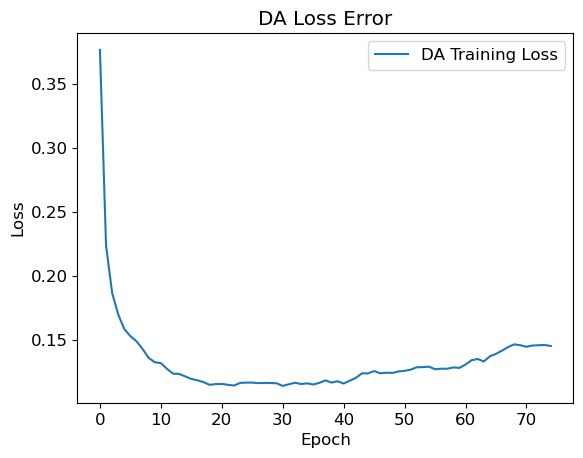

In [13]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

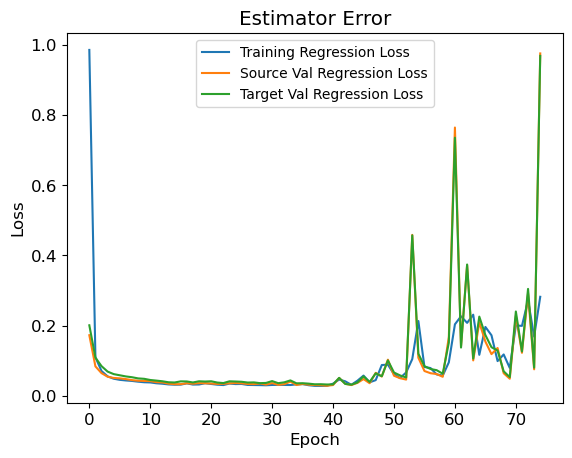

In [14]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 10.0)

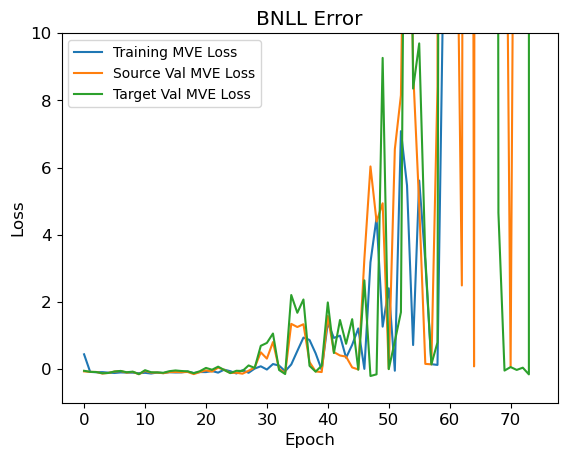

In [15]:
# Estimator
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 10)

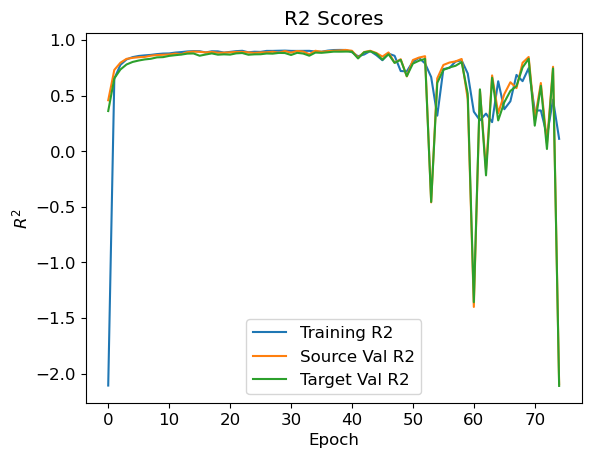

In [16]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()

Source R2 Score is -2.1589


Text(0.5, 1.0, 'MMD | Source | R2: -2.159')

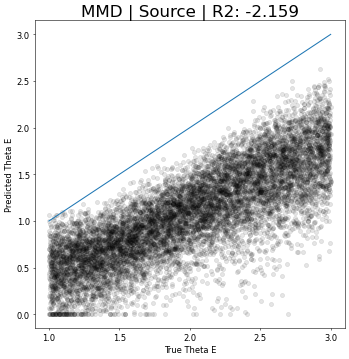

In [17]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: 0.413')

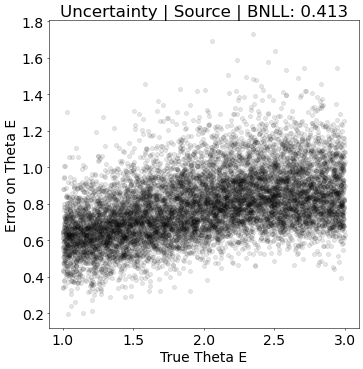

In [18]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [19]:
beta_val = 1 - ((46 / 100) * 0.7 )

In [20]:
beta_val

0.6779999999999999

Target R2 Score is -2.0736


Text(0.5, 1.0, 'MMD | Target | R2: -2.074')

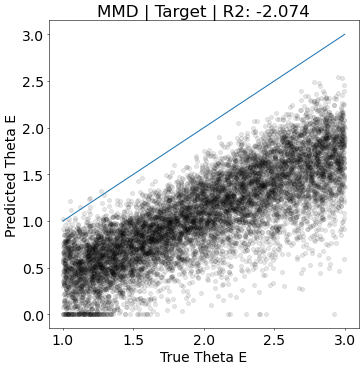

In [21]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: 1.022')

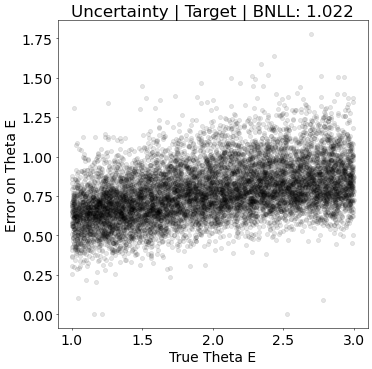

In [22]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [23]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

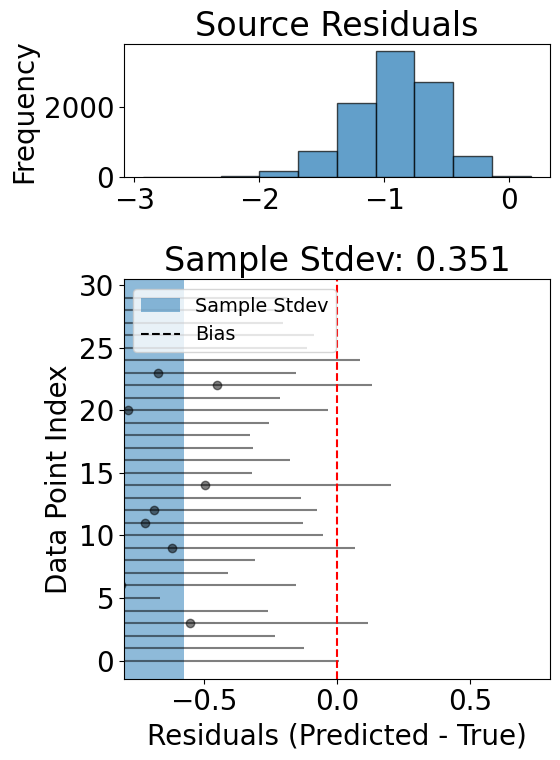

In [24]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

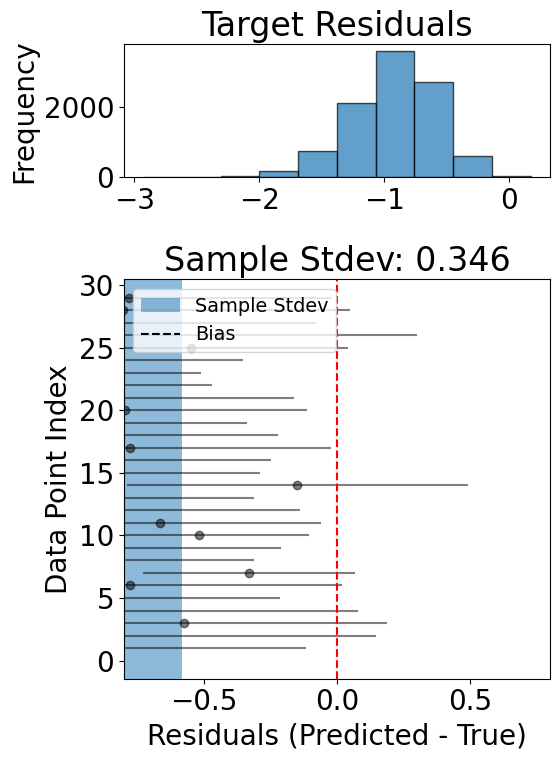

In [25]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

In [26]:
idx = (np.abs(true - preds) > 0.7)

NameError: name 'true' is not defined

In [80]:
preds

array([1.30214167, 2.98077202, 2.00425458, ..., 0.95970899, 3.07219529,
       2.18891573])

In [81]:
true

array([1.69164467, 3.9343679 , 2.13911223, ..., 1.52133608, 2.09088802,
       2.36884522])

3.9343678951263428
2.980772018432617


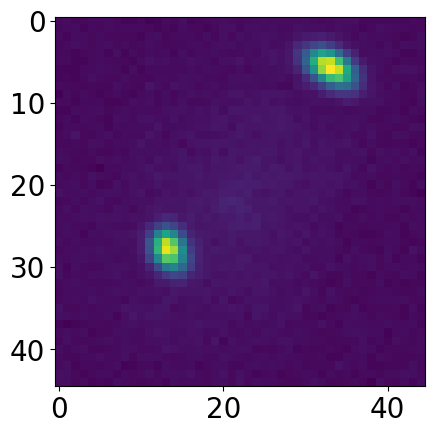

In [82]:
i = 0
b = 0
plt.imshow(imgs[idx][i, b, :, :])
print(true[idx][0])
print(preds[idx][0])

1.154159426689148
2.234156370162964


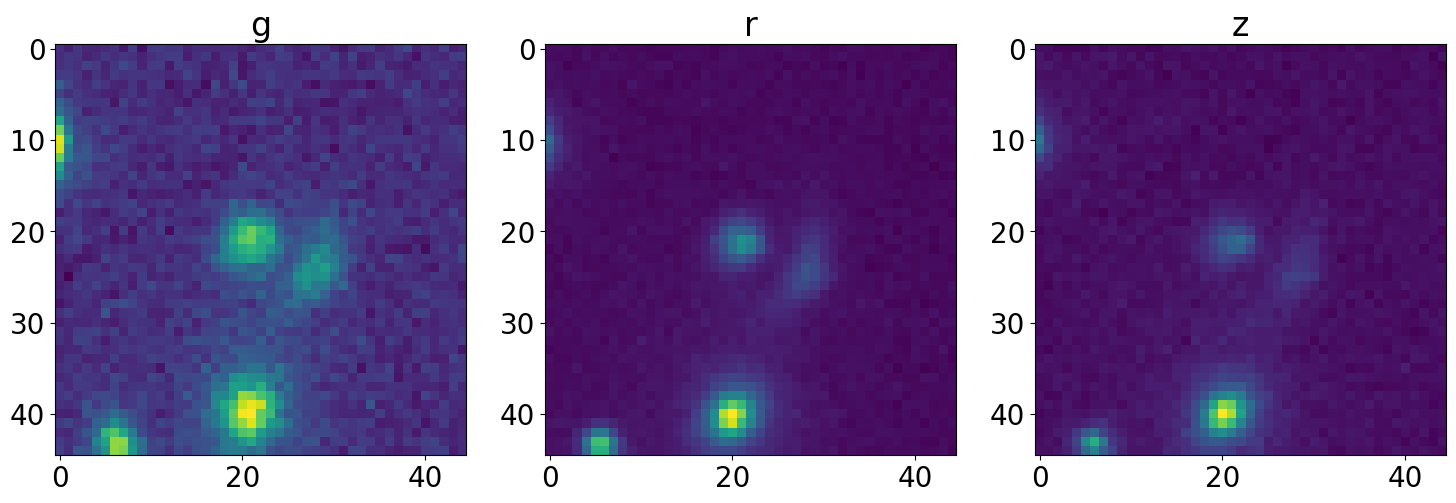

In [117]:
i = 134
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(imgs[idx][i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(imgs[idx][i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(imgs[idx][i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

print(true[idx][i])
print(preds[idx][i])
# Show the plot
plt.show()

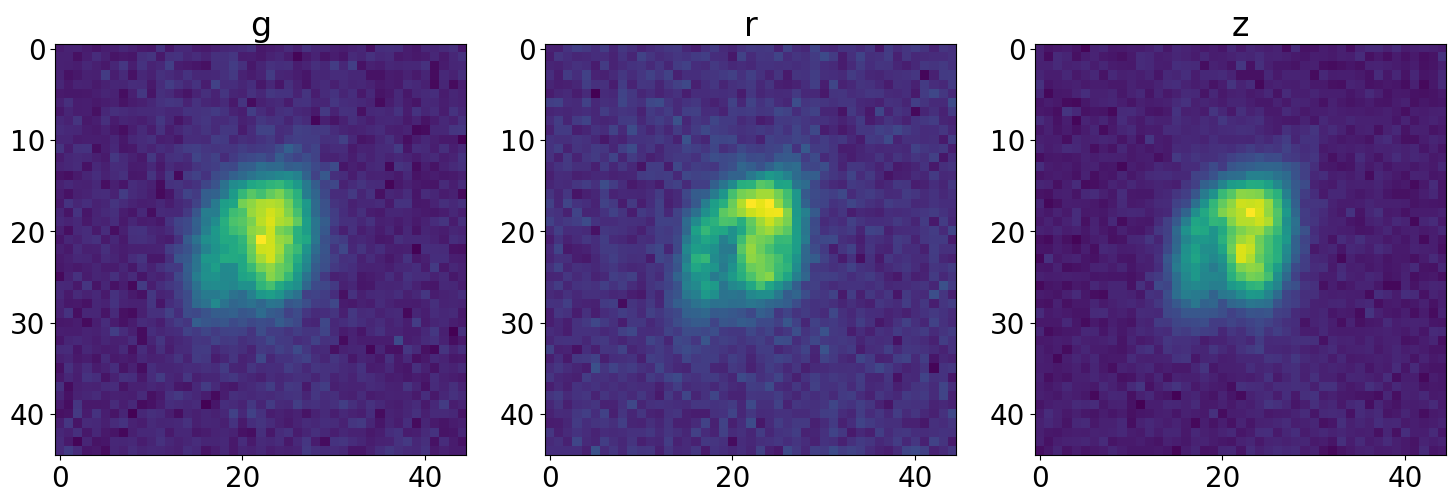

In [105]:
i = 16
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(source_data[i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(source_data[i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(source_data[i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()